In [1]:
import csv

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from sklearn import datasets
from tqdm.notebook import tqdm
from IPython.display import clear_output, display
torch.manual_seed(32)

In [2]:
f = True
X = []
y = []


with open(
    "../../data/diabetes1.csv",
    newline="",
) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if f:
            print(row)
            f = False
        if float(row["Glucose"]) < 50:
            continue
        X.append(np.array([float(row["Age"]), float(row["Glucose"])]))
        y.append(np.intc(1 if row["Outcome"].strip().upper() == "1" else 0))


with open(
    "../../data/diabetes2.csv",
    newline="",
) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        if f:
            print(row)
            f = False
        if float(row["Glucose"]) < 50:
            continue
        X.append(np.array([float(row["Age"]), float(row["Glucose"])]))
        y.append(np.intc(1 if row["Outcome"].strip().upper() == "1" else 0))


X = np.array(X)
y = np.array(y)

x_data = torch.Tensor(X)
y_data = torch.Tensor(y.reshape(len(X), 1))

{'Pregnancies': '6', 'Glucose': '148', 'BloodPressure': '72', 'SkinThickness': '35', 'Insulin': '0', 'BMI': '33.6', 'DiabetesPedigreeFunction': '0.627', 'Age': '50', 'Outcome': '1'}


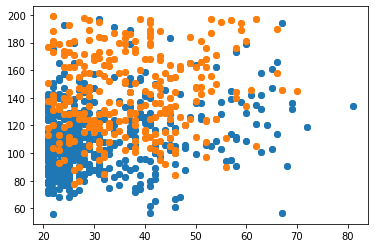

In [3]:
plt.scatter(X[y == 0, 0], X[y == 0, 1])
plt.scatter(X[y == 1, 0], X[y == 1, 1])

In [4]:
class Model(nn.Module):
    def __init__(self, input_size, layers, output_size):
        super().__init__()
        self.layers = []
        first = True
        for node_size in layers:
            if first:
                item = nn.Linear(input_size, layers[0])
                setattr(self, str(hash(item)), item)
                self.layers.append(item)
                previous_node_size = layers[0]
                first = False
                continue
            else:
                item = nn.Linear(previous_node_size, node_size)
                setattr(self, str(hash(item)), item)
                self.layers.append(item)
            previous_node_size = node_size
        item = nn.Linear(previous_node_size, output_size)
        setattr(self, str(hash(item)), item)
        self.layers.append(item)

    def forward(self, x):
        for layer in self.layers:
            x = torch.sigmoid(layer(x))
        return x

    def predict(self, x):
        pred = self.forward(x)
        if pred >= 0.5:
            return 1
        else:
            return 0

In [5]:
model = Model(2, [20, 20], 1)
# print(list(model.parameters()))
print("Untrained Network")
plot_decision_boundry(X, y)

Untrained Network


NameError: name 'plot_decision_boundry' is not defined

In [ ]:
model.layers

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
def plot_decision_boundry(X, y, scatter=False):
    x_span = np.linspace(min(X[:, 0]) - 0.25, max(X[:, 0] + 0.25))
    y_span = np.linspace(min(X[:, 1]) - 0.25, max(X[:, 1] + 0.25))
    xx, yy = np.meshgrid(x_span, y_span)
    grid = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    pred_func = model.forward(grid)
    z = pred_func.view(xx.shape).detach().numpy()
    plt.contourf(xx, yy, z)
    if scatter:
        plt.scatter(X[y == 0, 0], X[y == 0, 1])
        plt.scatter(X[y == 1, 0], X[y == 1, 1])
    plt.show()

In [ ]:
epochs = 4000
losses = []

progress_bar = tqdm(range(epochs))
for i in progress_bar:
    if i % 500 == 1:

        plot_decision_boundry(X, y)
    y_pred = model.forward(x_data)
    loss = criterion(y_pred, y_data)
    losses.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    progress_bar.set_description(f"epoch: {i} loss: {loss.item()}")

In [ ]:
plt.plot(range(epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epoc")
print("Loss over time")

In [ ]:
print("Trained Network")
plot_decision_boundry(X, y)

In [ ]:
print("Trained Network With data")
plot_decision_boundry(X, y, scatter=True)

In [ ]:
age = 33
bgl = 103
point = torch.Tensor([age, bgl])

pred = model.predict(point)
print("First Prediction, 33 years old with BGL 103, group 0 = No Diabetus")
print(pred)
print(model.forward(point).item())
plt.plot([age], [bgl], "or")
plot_decision_boundry(X, y)

In [ ]:
age = 36
bgl = 120
point = torch.Tensor([age, bgl])

pred = model.predict(point)
print("Second Prediction, 36 Years old with BGL 120, group 0 = No Diabetus")
print(pred)
print(model.forward(point).item())
plt.plot([age], [bgl], "or")
plot_decision_boundry(X, y)

In [ ]:
age = 36
bgl = 140
point = torch.Tensor([age, bgl])

pred = model.predict(point)
print("Second Prediction, 36 Years old with BGL 140, group 1 =  Diabetus")
print(pred)
print(model.forward(point).item())
plt.plot([age], [bgl], "or")
plot_decision_boundry(X, y)